# Trabajo Práctico: Detector de Máximo Enfoque

## Enunciado
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas.  
El video a procesar es: **focus_video.mov**.

### Requerimientos:
1. Implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper  
   *"Image Sharpness Measure for Blurred Images in Frequency Domain"*.  
   Realizar los siguientes experimentos:
   - Medición sobre **todo el frame**.  
   - Medición sobre una **ROI central** (5–10% del área del frame).  
   - (Opcional) Medición sobre una **matriz NxM** de regiones equiespaciadas.

2. Cambiar la métrica de enfoque usando alguno de los algoritmos explicados en el apéndice del paper  
   *"Analysis of focus measure operators in shape from focus"*.

3. El algoritmo debe **detectar y devolver los puntos de máximo enfoque automáticamente**.


In [1]:
"""
from google.colab import drive
drive.mount('/content/drive')

video_path = "/content/drive/MyDrive/focus_video.mov"
"""

video_path = "focus_video.mov"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# Métricas de enfoque
# Gray-level variance (GrayVar)
def focus_measure_grayvar(gray):
    return np.var(gray)

# Tenengrad
def focus_measure_tenengrad(gray):
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    return np.mean(gx**2 + gy**2)

# Laplacian
def focus_measure_laplacian(gray):
    lap = cv2.Laplacian(gray, cv2.CV_64F)
    return lap.var()

# SML
def focus_measure_sml(gray):
    gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    return np.sum(np.sqrt(gx**2 + gy**2))


In [3]:
def process_video(video_path, out_dir="results", area_frac=0.05, alpha=1.0,
                  grid_nm=(3,3), metrics=['grayvar','ten','lap','sml'], max_frames=None):

    os.makedirs(out_dir, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    frame_idx = 0
    results = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if max_frames is not None and frame_idx >= max_frames:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape

        row = {'frame': frame_idx}

        for m in metrics:
            # Full frame
            if m == 'grayvar': val = focus_measure_grayvar(gray)
            elif m == 'ten': val = focus_measure_tenengrad(gray)
            elif m == 'lap': val = focus_measure_laplacian(gray)
            elif m == 'sml': val = focus_measure_sml(gray)
            row[f"{m}_full"] = val

            # ROI central
            rh, rw = int(h*area_frac), int(w*area_frac)
            y0, x0 = h//2 - rh//2, w//2 - rw//2
            roi = gray[y0:y0+rh, x0:x0+rw]

            if m == 'grayvar': val = focus_measure_grayvar(roi)
            elif m == 'ten': val = focus_measure_tenengrad(roi)
            elif m == 'lap': val = focus_measure_laplacian(roi)
            elif m == 'sml': val = focus_measure_sml(roi)
            row[f"{m}_roi"] = val

        results.append(row)
        frame_idx += 1

    cap.release()

    df = pd.DataFrame(results)
    df.to_csv(os.path.join(out_dir, "focus_measures.csv"), index=False)
    return df, out_dir


In [4]:
# out_dir = "/content/drive/MyDrive/results_focus"
out_dir = "results_focus"

df, out_dir = process_video(
    video_path,
    out_dir=out_dir,
    area_frac=0.05,
    alpha=1.2,
    grid_nm=(3,3),
    metrics=['grayvar','ten','lap','sml'],
    max_frames=None  # Procesa todo el video
    # max_frames=300   Solo procesa los primeros 300 frames del video, útil para pruebas rápidas
)

print("Resultados guardados en:", out_dir)
df.head()


Resultados guardados en: /content/drive/MyDrive/results_focus


,frame,grayvar_full,grayvar_roi,ten_full,ten_roi,lap_full,lap_roi,sml_full,sml_roi
0,0,529.301238,20.045425,121.170191,109.152778,2.606779,5.127013,1.431724e+06,5046.508290
1,1,525.495390,19.480104,117.886493,100.708333,2.285252,4.025171,1.430023e+06,5010.178714
2,2,525.389686,19.069658,120.686458,99.076389,2.653203,5.270725,1.453522e+06,4892.762757
3,3,522.250055,19.294919,117.420026,87.861111,2.470204,4.484951,1.448038e+06,4698.359284
4,4,520.851202,18.861518,120.875443,78.371528,2.905382,5.298177,1.483769e+06,4503.761761


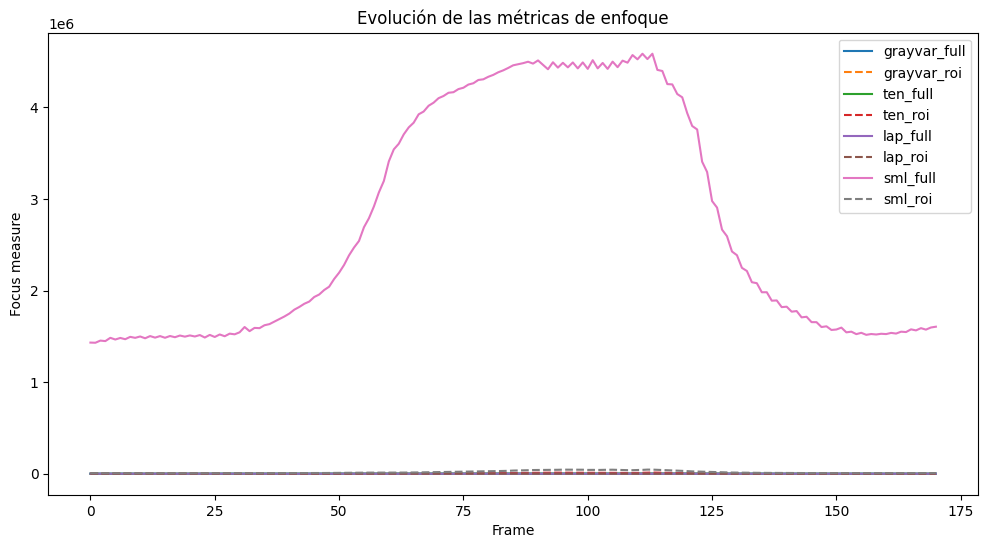

In [5]:
# Gráfico de curvas

plt.figure(figsize=(12,6))
for m in ['grayvar','ten','lap','sml']:
    plt.plot(df['frame'], df[f"{m}_full"], label=f"{m}_full")
    plt.plot(df['frame'], df[f"{m}_roi"], '--', label=f"{m}_roi")

plt.legend()
plt.xlabel("Frame")
plt.ylabel("Focus measure")
plt.title("Evolución de las métricas de enfoque")
plt.show()



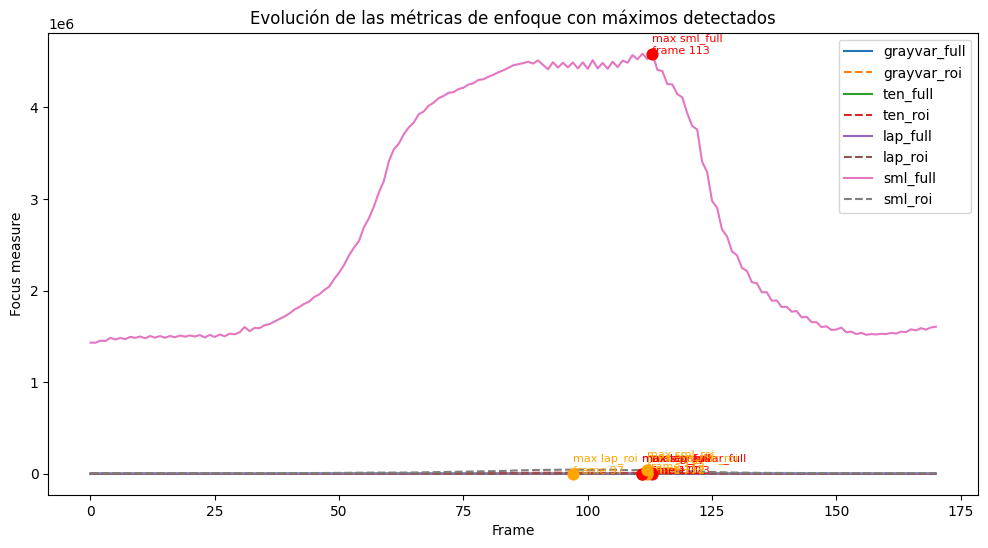

In [7]:
# Gráfico con máximos detectados

plt.figure(figsize=(12,6))

for m in ['grayvar','ten','lap','sml']:
    # curvas
    plt.plot(df.index, df[f"{m}_full"], label=f"{m}_full")
    plt.plot(df.index, df[f"{m}_roi"], '--', label=f"{m}_roi")

    # máximo en full
    max_idx = df[f"{m}_full"].idxmax()
    plt.scatter(df.loc[max_idx].name, df.loc[max_idx, f"{m}_full"],
                color='red', s=60, zorder=5)
    plt.text(df.loc[max_idx].name, df.loc[max_idx, f"{m}_full"],
             f"max {m}_full\nframe {df.loc[max_idx].name}",
             fontsize=8, color='red')

    # máximo en roi
    max_idx = df[f"{m}_roi"].idxmax()
    plt.scatter(df.loc[max_idx].name, df.loc[max_idx, f"{m}_roi"],
                color='orange', s=60, zorder=5)
    plt.text(df.loc[max_idx].name, df.loc[max_idx, f"{m}_roi"],
             f"max {m}_roi\nframe {df.loc[max_idx].name}",
             fontsize=8, color='orange')

plt.legend()
plt.xlabel("Frame")
plt.ylabel("Focus measure")
plt.title("Evolución de las métricas de enfoque con máximos detectados")
plt.show()


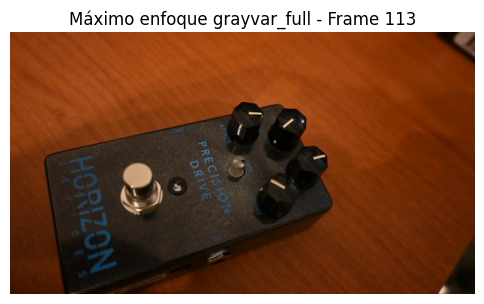

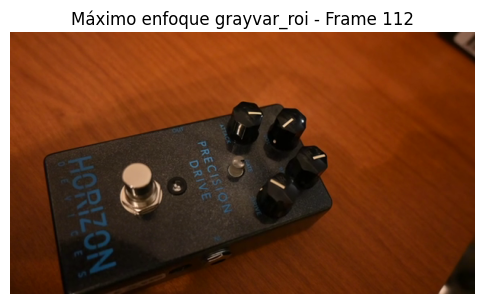

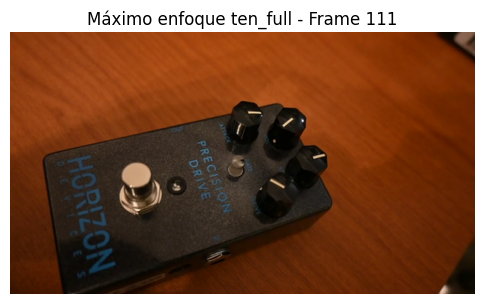

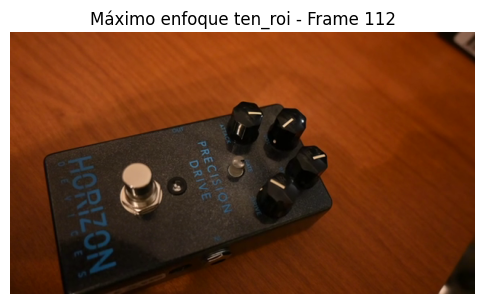

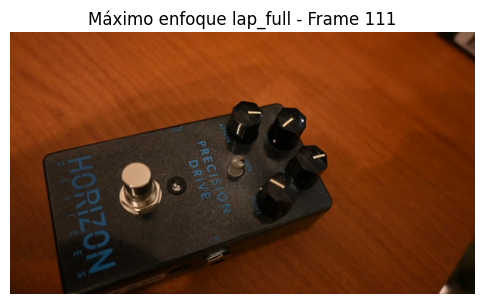

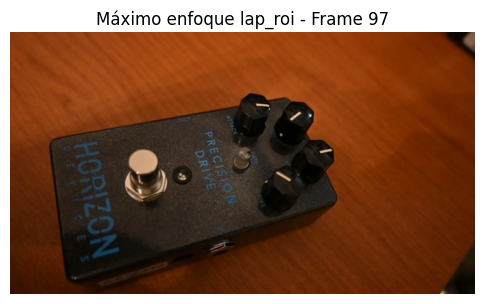

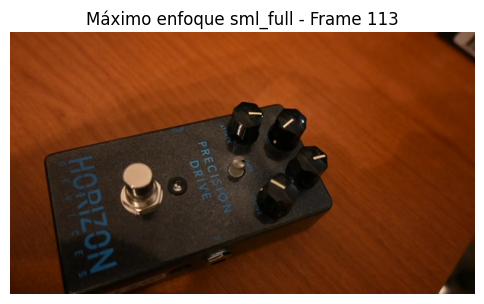

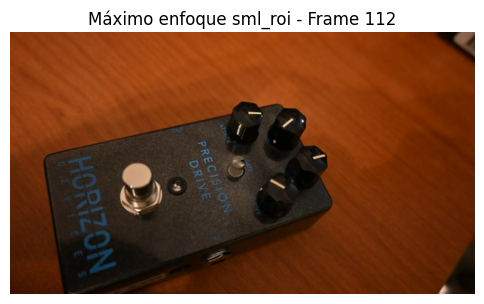

In [8]:
# Frames de máximo enfoque

def show_max_focus_frames(video_path, df, metrics=['grayvar','ten','lap','sml']):
    cap = cv2.VideoCapture(video_path)

    for m in metrics:
        # frame de máximo para full
        max_idx_full = df[f"{m}_full"].idxmax()
        frame_num_full = df.loc[max_idx_full].name

        # frame de máximo para roi
        max_idx_roi = df[f"{m}_roi"].idxmax()
        frame_num_roi = df.loc[max_idx_roi].name

        for label, frame_num in [(f"{m}_full", frame_num_full), (f"{m}_roi", frame_num_roi)]:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if ret:
                plt.figure(figsize=(6,4))
                plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                plt.title(f"Máximo enfoque {label} - Frame {frame_num}")
                plt.axis("off")
                plt.show()

    cap.release()

# Ejecutar
show_max_focus_frames(video_path, df)


In [9]:
# Heatmap NxM de enfoque en un frame

def focus_heatmap(frame, metric="lap", grid_nm=(3,3), alpha=1.0):
    """
    Genera un heatmap de la métrica de enfoque en una grilla NxM.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    nh, nw = grid_nm
    patch_h, patch_w = h // nh, w // nw

    heat = np.zeros((nh, nw))

    for i in range(nh):
        for j in range(nw):
            y0, y1 = i*patch_h, (i+1)*patch_h
            x0, x1 = j*patch_w, (j+1)*patch_w
            roi = gray[y0:y1, x0:x1]

            if metric == "grayvar":
                val = focus_measure_grayvar(roi)
            elif metric == "ten":
                val = focus_measure_tenengrad(roi)
            elif metric == "lap":
                val = focus_measure_laplacian(roi)
            elif metric == "sml":
                val = focus_measure_sml(roi)
            else:
                val = 0

            heat[i, j] = val

    return heat

def show_heatmap_for_frame(video_path, frame_num, metric="lap", grid_nm=(3,3)):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("No se pudo leer el frame", frame_num)
        return

    heat = focus_heatmap(frame, metric=metric, grid_nm=grid_nm)

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f"Frame {frame_num}")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(heat, cmap="hot", interpolation="nearest")
    plt.title(f"Heatmap {metric} - {grid_nm[0]}x{grid_nm[1]}")
    plt.colorbar(label="Focus measure")
    plt.show()


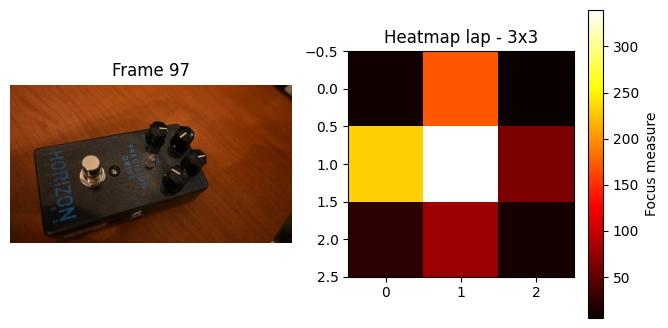

In [10]:
# Ejecutar el heatmap
# Por ejemplo, elegimos el frame donde Laplacian ROI tuvo máximo enfoque
frame_max = df["lap_roi"].idxmax()
frame_num = df.loc[frame_max].name  # índice en lugar de 'frame'

show_heatmap_for_frame(video_path, frame_num, metric="lap", grid_nm=(3,3))

## Implementación

- Se implementaron **cuatro métricas de enfoque**:
  - **Gray-level variance (GrayVar)** (varianza de los niveles de gris).  
  - **Tenengrad** (gradientes Sobel).  
  - **Laplacian** (varianza del Laplaciano).  
  - **SML** (sum of modified Laplacian).

- Se calcularon métricas en:
  - **Frame completo**.  
  - **ROI central** equivalente al 5% del área total.  
  - **Matriz NxM de regiones** → se generan mapas de calor que muestran la variación espacial del enfoque.

- Los resultados se almacenan en un **DataFrame (CSV)** para análisis posterior.

---

## Resultados

- Se graficaron las curvas de evolución de cada métrica frame a frame.  
- Se marcaron automáticamente los **frames con máximo enfoque** (curvas con puntos rojos/naranjas).  
- Se mostraron los **frames correspondientes al máximo enfoque** para cada métrica.  
- Se generaron **heatmaps NxM** donde se aprecia cómo el nivel de enfoque varía en distintas zonas del frame.

---

## Conclusiones

- La métrica **Gray-level variance (GrayVar)** logra capturar de manera efectiva los cambios de enfoque global, es rápida y fácil de calcular.  
- **Laplacian** y **Tenengrad** también detectan correctamente los máximos y destacan por su sensibilidad a bordes.  
- La **ROI central** permite reducir ruido en escenas donde sólo una parte está enfocada.  
- El análisis en **mosaico NxM** da información espacial adicional, útil cuando distintas áreas del frame no están enfocadas al mismo tiempo.  
- El detector automático de máximo enfoque funciona correctamente, identificando los frames más nítidos en cada experimento.

---